In [1]:
import yaml
import pandas as pd
from pathlib import Path
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from proteins.config import flatten_dict

ix = pd.IndexSlice
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

## Import experiment results

In [2]:
from collections import defaultdict

df = defaultdict(list)
skip = []

for p in Path('.').glob('runs/*/*.yaml'):
    with open(p) as ex:
        ex = yaml.safe_load(ex)
    if ex['history'][-1]['status'] != 'COMPLETED':
        skip.append(p)
    else:
        df['misc', 'tags', '', ''].append(','.join(ex['tags']))
        df['misc', 'comment', '', ''].append(ex.get('comment', None))
        df['misc', 'ablation', '', ''].append(ex['tags'][1]) # nodes or edges
        df['misc', 'name', '', ''].append('_'.join(ex['fullname'].split('_')[-2:]))
        df['misc', 'time', '', ''].append((ex['history'][-1]['datetime_completed'] - ex['history'][-1]['datetime_started']).total_seconds() / 60)
        df['misc', 'gpu', '', ''].append(int(ex['history'][-1]['cuda']['devices']['cuda:0']['memory_used_max'].rstrip(' MiB')))
        df['hp', 'epochs', '', ''].append(ex['completed_epochs'])
        
        for k, v in flatten_dict(ex['data']):
            df[('hp', 'data', *k, '')].append(v)
            
        for k, v in flatten_dict(ex['model']):
            df[('hp', 'model', *k, '')].append(v)
        if 'mp_in_globals' not in ex['model']:
            df[('hp', 'model', 'mp_in_globals', '')].append(None)
        if 'mp_out_globals' not in ex['model']:
            df[('hp', 'model', 'mp_out_globals', '')].append(None)
            
        for k, v in flatten_dict(ex['optimizer']):
            df[('hp', 'optimizer', *k, '')].append(v)
        
        for k, v in flatten_dict(ex['loss']):
            df[('hp', 'loss', *k)].append(v)
        
        for k, v in flatten_dict(ex['history'][-1]['metric']):
            df[('metric', *k, '')].append(v)
                   
df = pd.DataFrame(df).sort_index(axis='columns', inplace=False)
df[('misc','tags','','')] = df[('misc','tags','','')].str.replace('posemb','posenc')
        
print(f'Skipped {len(skip)}')
print(f'Good {len(df)}')
df.iloc[0].to_frame('Example')

Skipped 0
Good 463


Example
hp     data         cutoff                        12                            
                    dssp_features                 True                          
                    encoding_base                 0                             
                    encoding_size                 0                             
                    partial_entropy               True                          
                    residues                      True                          
                    self_info                     True                          
                    separation                    True                          
                    sigma                         15                            
       epochs                                     30                            
       loss         global_gdtts        balanced  False                         
                                        name      mse                           
                                        weight    5                             
                    global_lddt         balanced  False                         
                                        name      mse                           
                                        weight    1                             
                    local_lddt          balanced  False                         
                                        name      mse                           
                                        weight    5                             
       model        batch_norm                    False                         
                    dropout                       0.2                           
                    enc_in_edges                  8                             
                    enc_in_nodes                  83                            
                    fn                            proteins.networks.ProteinGN   
                    layers                        9                             
                    mp_in_edges                   128                           
                    mp_in_globals                 512                           
                    mp_in_nodes                   512                           
                    mp_out_edges                  16                            
                    mp_out_globals                32                            
                    mp_out_nodes                  64                            
       optimizer    fn                            torch.optim.Adam              
                    lr                            0.001                         
                    weight_decay                  1e-05                         
metric global_gdtts first_rank_loss               0.0726565                     
                    kendall                       0.744133                      
                    pearson                       0.91203                       
                    per_target_kendall            0.461051                      
                    per_target_pearson            0.732533                      
                    per_target_spearman           0.618544                      
                    rmse                          0.112294                      
                    spearman                      0.916985                      
       global_lddt  first_rank_loss               0.0455047                     
                    kendall                       0.765269                      
                    pearson                       0.920003                      
                    per_target_kendall            0.583391                      
                    per_target_pearson            0.829865                      
                    per_target_spearman           0.751825                      
                    rmse                          0.0802374                     
                    spe

For each ablation type, how many experiments do we have?

In [3]:
df_counts = df.groupby(('misc','tags')).size().to_frame('Count').rename_axis(index='Tags')
df_counts.index = df_counts.index.str.replace('ablation,','').str.split(',',n=1,expand=True).rename(['Type', 'Features'])
display(df_counts.sort_index())
del df_counts

Count
Type             Features                                     
architecture     globalno                                10   
                 globalyes                               10   
edges            peptide                                 16   
                 peptide,contacts                        16   
                 peptide,contacts,distance,sepenc        16   
                 peptide,contacts,distances              16   
                 peptide,contacts,sepenc                 16   
layersvscutoff   globalno,l3,c0                          10   
                 globalno,l3,c10                         10   
                 globalno,l3,c12                         10   
                 globalno,l3,c14                         10   
                 globalno,l3,c6                          10   
                 globalno,l3,c8                          10   
                 globalno,l6,c0                          10   
                 globalno,l6,c10                         10   
                 globalno,l6,c12                         10   
                 globalno,l6,c6                          10   
                 globalno,l6,c8                          10   
                 globalno,l9,c0                          10   
                 globalno,l9,c10                         10   
                 globalno,l9,c6                          10   
                 globalno,l9,c8                          10   
                 l3,c0                                   5    
                 l3,c10                                  5    
                 l3,c12                                  5    
                 l3,c14                                  5    
                 l3,c6                                   5    
                 l3,c8                                   5    
                 l6,c0                                   5    
                 l6,c10                                  5    
                 l6,c12                                  5    
                 l6,c14                                  5    
                 l6,c6                                   5    
                 l6,c8                                   5    
                 l9,c0                                   5    
                 l9,c10                                  4    
                 l9,c12                                  4    
                 l9,c6                                   5    
                 l9,c8                                   5    
localglobalscore global                                  5    
                 local                                   5    
                 local,global                            5    
nodes            residues                                16   
                 residues,dssp                           16   
                 residues,dssp,posenc                    6    
                 residues,partentr                       15   
                 residues,partentr,selfinfo,dssp         15   
                 residues,partentr,selfinfo,dssp,posenc  16   
                 residues,posenc                         15   
                 residues,selfinfo                       16

## Nodes

,Comment
Node Features,
Residues,"ablation study for node feature, using residue identity only"
"Residues, DSSP","ablation study for node feature, using residue identity and dssp features"
"Residues, Part Entr","ablation study for node feature, using residue identity and partial entropy"
"Residues, Self Info","ablation study for node feature, using residue identity and self information"
All,"ablation study for node feature, using residue identity, partial entropy, self info and dssp features"


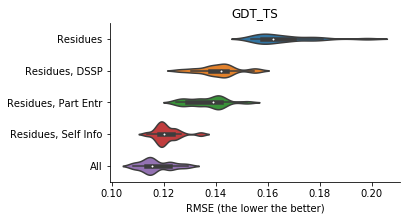

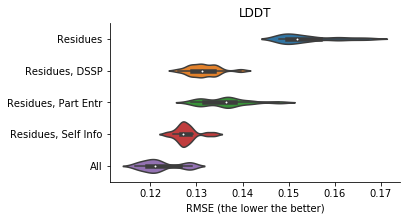

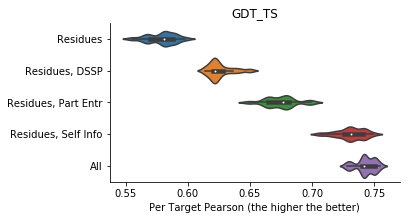

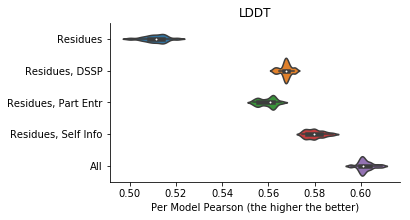

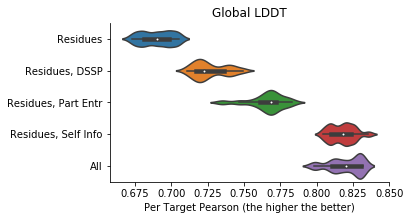

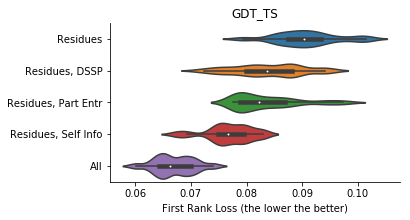

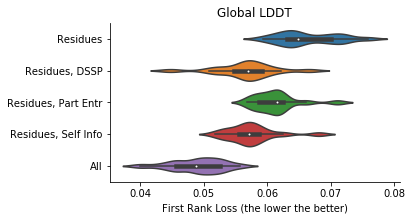

In [4]:
df_nodes = df[df.misc.tags.str.contains('nodes')].set_index(('misc','tags','',''))
df_nodes = df_nodes[~df_nodes.index.str.contains('posenc')]
df_nodes = df_nodes.loc[sorted(df_nodes.index.values, key=lambda s: (s.count(','), s))]
df_nodes.index = df_nodes.index.rename('Node Features') \
    .str.replace('ablation,nodes,','') \
    .str.replace('residues,partentr,selfinfo,dssp', 'All') \
    .str.replace('residues', 'Residues') \
    .str.replace('dssp', 'DSSP') \
    .str.replace('partentr', 'Part Entr') \
    .str.replace('selfinfo', 'Self Info') \
    .str.replace(',', ', ')
display(df_nodes.misc.comment.drop_duplicates().to_frame('Comment'))

for title, slicer in {
    ('GDT_TS','RMSE'): ('metric','global_gdtts','rmse',''),
    ('LDDT','RMSE'): ('metric','local_lddt','rmse',''),
    ('GDT_TS','Per Target Pearson'): ('metric','global_gdtts','per_target_pearson',''),
    ('LDDT','Per Model Pearson'): ('metric','local_lddt','per_model_pearson',''),
    ('Global LDDT','Per Target Pearson'): ('metric','global_lddt','per_target_pearson',''),
    ('GDT_TS','First Rank Loss'): ('metric','global_gdtts','first_rank_loss',''),
    ('Global LDDT','First Rank Loss'): ('metric','global_lddt','first_rank_loss',''),
}.items():
    b = sns.catplot(
        y=('Node Features','','',''), 
        x=slicer, 
        kind="violin", 
        data=df_nodes.reset_index(), 
        aspect=2,
        height=3,
    )
    b.fig.set_facecolor('white')
    b.ax.set_ylabel(None)
    b.ax.set_title(title[0])
    b.ax.set_xlabel(title[1] + (' (the lower the better)' if 'Loss' in title[1] or 'RMSE' in title[1] else ' (the higher the better)'))
    
    b.fig.savefig(f'./nodefeatures_{slicer[1].split("_")[1]}_{slicer[2]}.pdf')
    display(b.fig)
    plt.close(b.fig)

78


,Comment
Node Features,
Residues,"ablation study for node feature, using residue identity only"
"Residues, Self Info","ablation study for node feature, using residue identity and self information"
"Residues, DSSP","ablation study for node feature, using residue identity and dssp features"
"Residues, Part Entr","ablation study for node feature, using residue identity and partial entropy"
All,"ablation study for node feature, using residue identity, partial entropy, self info and dssp features"


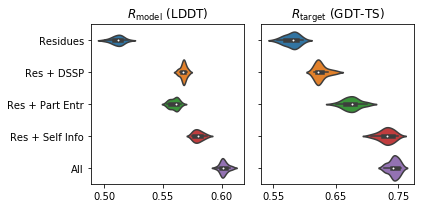

In [5]:
df_nodes = df[df.misc.tags.str.contains('nodes') & ~df.misc.tags.str.contains('posenc')].set_index(('misc','tags','',''))
df_nodes.index = df_nodes.index.rename('Node Features') \
    .str.replace('ablation,nodes,','') \
    .str.replace('residues,partentr,selfinfo,dssp', 'All') \
    .str.replace('residues', 'Residues') \
    .str.replace('dssp', 'DSSP') \
    .str.replace('partentr', 'Part Entr') \
    .str.replace('selfinfo', 'Self Info') \
    .str.replace(',', ', ')
print(len(df_nodes))
display(df_nodes.misc.comment.drop_duplicates().to_frame('Comment'))

fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

ax = axes[0]
# sns.pointplot(
#     y=df_nodes.index, 
#     x=df_nodes.metric.local_lddt.per_model_pearson,
#     ax=ax,
#     order=['Residues', 'Residues, DSSP', 'Residues, Part Entr', 'Residues, Self Info', 'All'],
#     ci='sd',
#     markers='|',
#     scale=1.5,
#     capsize=.4,
#     join=False,
#     markersize=100,
# )
sns.violinplot(
    y=df_nodes.index, 
    x=df_nodes.metric.local_lddt.per_model_pearson,
    order=['Residues', 'Residues, DSSP', 'Residues, Part Entr', 'Residues, Self Info', 'All'],
    ax=ax,
)
ax.set_title(r'$R_\mathrm{model}$ (LDDT)')
ax.set_xlabel(None)
ax.set_ylabel(None)

ax = axes[1]
sns.violinplot(
    y=df_nodes.index, 
    x=df_nodes.metric.global_gdtts.per_target_pearson,
    order=['Residues', 'Residues, DSSP', 'Residues, Part Entr', 'Residues, Self Info', 'All'],
    ax=ax
)
ax.set_title(r'$R_\mathrm{target}$ (GDT-TS)')
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_xticks([.55, .65, .75])

ax.set_yticklabels(['Residues', 'Res + DSSP', 'Res + Part Entr', 'Res + Self Info', 'All'])

fig.tight_layout()
fig.savefig(f'./nodefeatures.pdf', bbox_inches='tight', pad_inches=0.01)
fig.set_facecolor('white')
display(fig)
plt.close(fig)

In [6]:
df_nodes = df[df.misc.tags.str.contains('nodes')].groupby(('misc','tags')).aggregate(['mean', 'std']).metric
df_nodes = df_nodes[~df_nodes.index.str.contains('posenc')]
df_nodes = df_nodes.loc[sorted(df_nodes.index.values, key=lambda s: (s.count(','), s))]
df_nodes.index = df_nodes.index.rename('Node Features') \
    .str.replace('ablation,nodes,','') \
    .str.replace('residues,partentr,selfinfo,dssp', 'All') \
    .str.replace('residues', 'Residues') \
    .str.replace('dssp', 'DSSP') \
    .str.replace('partentr', 'Part Entr') \
    .str.replace('selfinfo', 'Self Info') \
    .str.replace(',', ', ')
df_nodes.columns = df_nodes.columns.droplevel(2).remove_unused_levels()
df_nodes.round(3)

global_gdtts                                       \
                    first_rank_loss        kendall        pearson          
                               mean    std    mean    std    mean    std   
Node Features                                                              
Residues             0.091           0.006  0.601   0.016  0.801   0.017   
Residues, DSSP       0.084           0.006  0.676   0.012  0.853   0.014   
Residues, Part Entr  0.084           0.006  0.688   0.013  0.870   0.012   
Residues, Self Info  0.077           0.004  0.730   0.007  0.900   0.005   
All                  0.067           0.004  0.742   0.008  0.908   0.007   

                                                                         \
                    per_target_kendall        per_target_pearson          
                                  mean    std               mean    std   
Node Features                                                             
Residues             0.331              0.010  0.579              0.012   
Residues, DSSP       0.375              0.010  0.626              0.010   
Residues, Part Entr  0.407              0.011  0.675              0.013   
Residues, Self Info  0.446              0.007  0.731              0.011   
All                  0.466              0.004  0.743              0.008   

                                                                              \
                    per_target_spearman          rmse        spearman          
                                   mean    std   mean    std     mean    std   
Node Features                                                                  
Residues             0.462               0.014  0.166  0.012  0.802    0.015   
Residues, DSSP       0.518               0.012  0.141  0.008  0.862    0.012   
Residues, Part Entr  0.561               0.013  0.137  0.007  0.876    0.011   
Residues, Self Info  0.606               0.009  0.121  0.005  0.908    0.004   
All                  0.627               0.005  0.117  0.006  0.915    0.005   

                        global_lddt                                       \
                    first_rank_loss        kendall        pearson          
                               mean    std    mean    std    mean    std   
Node Features                                                              
Residues             0.066           0.005  0.646   0.013  0.834   0.013   
Residues, DSSP       0.057           0.005  0.704   0.008  0.873   0.010   
Residues, Part Entr  0.061           0.004  0.709   0.014  0.890   0.011   
Residues, Self Info  0.057           0.004  0.749   0.005  0.917   0.005   
All                  0.049           0.004  0.763   0.012  0.924   0.008   

                                                                         \
                    per_target_kendall        per_target_pearson          
                                  mean    std               mean    std   
Node Features                                                             
Residues             0.420              0.011  0.690              0.011   
Residues, DSSP       0.480              0.009  0.726              0.012   
Residues, Part Entr  0.496              0.010  0.766              0.012   
Residues, Self Info  0.537              0.007  0.818              0.009   
All                  0.562              0.010  0.820              0.011   

                                                                              \
                    per_target_spearman          rmse        spearman          
                                   mean    std   mean    std     mean    std   
Node Features                                                                  
Residues             0.576               0.013  0.114  0.007  0.842    0.011   
Residues, DSSP       0.641               0.011  0.100  0.004  0.881    0.008   
Residues, Part Entr  0.664               0.012  0.095  0.005  0.893    0.010   
Residues, Self Info 

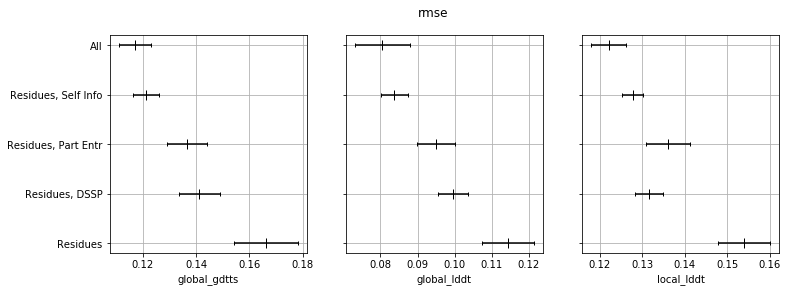

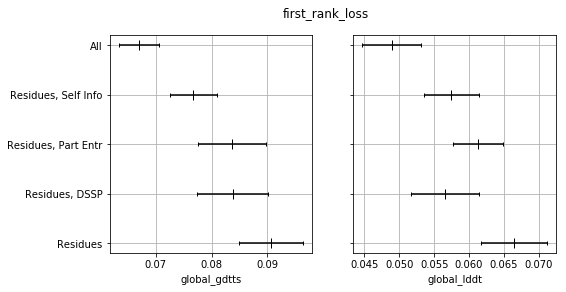

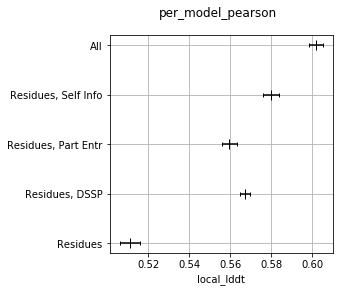

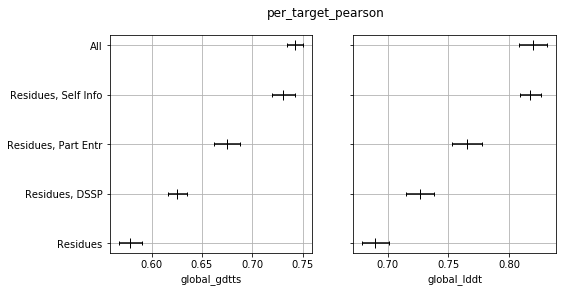

In [7]:
for metric in ['rmse', 'first_rank_loss', 'per_model_pearson', 'per_target_pearson']:
    df_metric = df_nodes.loc[:, ix[:, metric]].droplevel(1, axis='columns')
    df_metric.columns = df_metric.columns.remove_unused_levels()
        
    fig, axes = plt.subplots(1, len(df_metric.columns.levels[0]), squeeze=False, facecolor='white',
                             figsize=(4*len(df_metric.columns.levels[0]), 4), sharey=True)
    fig.suptitle(metric)
    
    for ax, col in zip(axes.flat, df_metric.columns.levels[0]):
        ax.errorbar(y=df_metric.index, x=df_metric[(col, 'mean')], xerr=df_metric[(col, 'std')], 
                    linestyle='', marker='|', markersize=10, color='k', ecolor='k', capsize=2)
        ax.set_xlabel(col)
        ax.grid()
    
    display(df_metric
            .style
            .background_gradient(subset=df_metric.columns.get_loc_level('mean', level=1)[0])
            .set_caption(f'<h3 align="left">{metric}</h3>')
    )
    display(fig)
    plt.close(fig)
    del df_metric

In [8]:
del df_nodes

## Edges

80


,Comment
Edge Features,
Bonds,"using peptide bonds only (cutoff 0), the graph is linear, distance RBF uninformative (sigma 1), separation uninformative"
All,"using peptide bonds and contacts (cutoff 8), distance RBF (sigma 15), separation encoding"
"Bonds, Contacts, Dist","using peptide bonds and contacts (cutoff 8), distance RBF (sigma 15), no separation (only binary feature bond/contact)"
"Bonds, Contacts, Sep Enc","using peptide bonds and contacts (cutoff 8), distance RBF uninformative (sigma 1), separation encoding"
"Bonds, Contacts","using peptide bonds and contacts (cutoff 8), distance RBF uninformative (sigma 1), no separation (only binary feature bond/contact)"


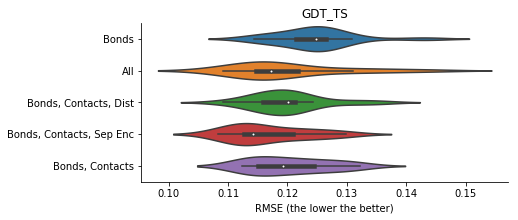

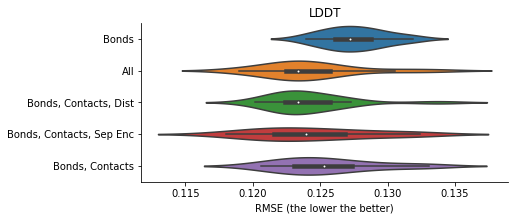

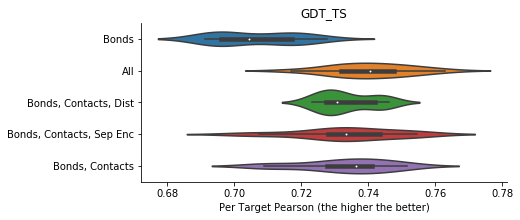

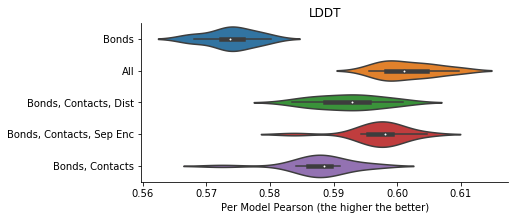

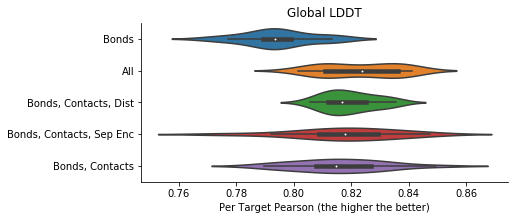

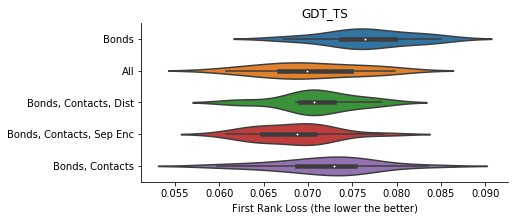

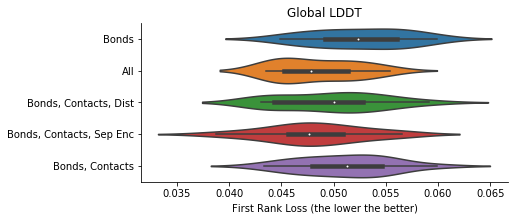

In [9]:
df_edges = df[df.misc.tags.str.contains('edges')].set_index(('misc','tags','',''))
df_edges.index = df_edges.index.rename('Edge Features') \
    .str.replace('ablation,edges,','') \
    .str.replace('peptide,contacts,distance,sepenc', 'All') \
    .str.replace('peptide', 'Bonds') \
    .str.replace('contacts', 'Contacts') \
    .str.replace('distances', 'Dist') \
    .str.replace('sepenc', 'Sep Enc') \
    .str.replace(',', ', ')
print(len(df_edges))
display(df_edges.misc.comment.drop_duplicates().to_frame('Comment'))


for title, slicer in {
    ('GDT_TS','RMSE'): ('metric','global_gdtts','rmse',''),
    ('LDDT','RMSE'): ('metric','local_lddt','rmse',''),
    ('GDT_TS','Per Target Pearson'): ('metric','global_gdtts','per_target_pearson',''),
    ('LDDT','Per Model Pearson'): ('metric','local_lddt','per_model_pearson',''),
    ('Global LDDT','Per Target Pearson'): ('metric','global_lddt','per_target_pearson',''),
    ('GDT_TS','First Rank Loss'): ('metric','global_gdtts','first_rank_loss',''),
    ('Global LDDT','First Rank Loss'): ('metric','global_lddt','first_rank_loss',''),
}.items():
    b = sns.catplot(
        y=('Edge Features','','',''), 
        x=slicer, 
        kind="violin", 
        data=df_edges.reset_index(), 
        aspect=2.5,
        height=3
    )
    b.fig.set_facecolor('white')
    b.ax.set_ylabel(None)
    b.ax.set_title(title[0])
    b.ax.set_xlabel(title[1] + (' (the lower the better)' if 'Loss' in title[1] or 'RMSE' in title[1] else ' (the higher the better)'))
    
    b.fig.savefig(f'./edgefeatures_{slicer[1].split("_")[1]}_{slicer[2]}.pdf')
    display(b.fig)
    plt.close(b.fig)

In [10]:
df_edges.index.unique()

Index(['Bonds', 'All', 'Bonds, Contacts, Dist', 'Bonds, Contacts, Sep Enc',
       'Bonds, Contacts'],
      dtype='object', name='Edge Features')

In [11]:
df[df.misc.tags.str.contains('edges') & (df.misc.tags != 'ablation,edges,peptide')].set_index(('misc','tags','','')).misc.comment.drop_duplicates().to_frame()

,comment
"(misc, tags, , )",
"ablation,edges,peptide,contacts,distance,sepenc","using peptide bonds and contacts (cutoff 8), distance RBF (sigma 15), separation encoding"
"ablation,edges,peptide,contacts,distances","using peptide bonds and contacts (cutoff 8), distance RBF (sigma 15), no separation (only binary feature bond/contact)"
"ablation,edges,peptide,contacts,sepenc","using peptide bonds and contacts (cutoff 8), distance RBF uninformative (sigma 1), separation encoding"
"ablation,edges,peptide,contacts","using peptide bonds and contacts (cutoff 8), distance RBF uninformative (sigma 1), no separation (only binary feature bond/contact)"


64


,Comment
Edge Features,
Dist + Sep Enc,"using peptide bonds and contacts (cutoff 8), distance RBF (sigma 15), separation encoding"
Distance,"using peptide bonds and contacts (cutoff 8), distance RBF (sigma 15), no separation (only binary feature bond/contact)"
Sep Enc,"using peptide bonds and contacts (cutoff 8), distance RBF uninformative (sigma 1), separation encoding"
Edge Type,"using peptide bonds and contacts (cutoff 8), distance RBF uninformative (sigma 1), no separation (only binary feature bond/contact)"


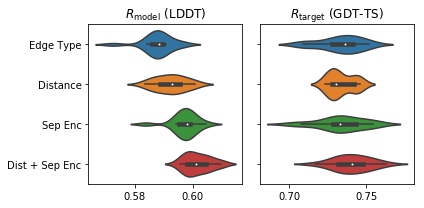

In [12]:
df_edges = df[df.misc.tags.str.contains('edges') & (df.misc.tags != 'ablation,edges,peptide')].set_index(('misc','tags','',''))
df_edges.index = df_edges.index.rename('Edge Features') \
    .str.replace('ablation,edges,peptide,contacts,distance,sepenc', 'Dist + Sep Enc') \
    .str.replace('ablation,edges,peptide,contacts,distances', 'Distance') \
    .str.replace('ablation,edges,peptide,contacts,sepenc', 'Sep Enc') \
    .str.replace('ablation,edges,peptide,contacts', 'Edge Type')
print(len(df_edges))
display(df_edges.misc.comment.drop_duplicates().to_frame('Comment'))

fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

ax = axes[0]
sns.violinplot(
    y=df_edges.index, 
    x=df_edges.metric.local_lddt.per_model_pearson,
    order=['Edge Type', 'Distance', 'Sep Enc', 'Dist + Sep Enc'],
    ax=ax,
)
ax.set_title(r'$R_\mathrm{model}$ (LDDT)')
ax.set_xlabel(None)
ax.set_ylabel(None)

ax = axes[1]
sns.violinplot(
    y=df_edges.index, 
    x=df_edges.metric.global_gdtts.per_target_pearson,
    order=['Edge Type', 'Distance', 'Sep Enc', 'Dist + Sep Enc'],
    ax=ax
)
ax.set_title(r'$R_\mathrm{target}$ (GDT-TS)')
ax.set_xlabel(None)
ax.set_ylabel(None)

ax.set_yticklabels(['Edge Type', 'Distance', 'Sep Enc', 'Dist + Sep Enc'])
ax.set_xticks([.7, .75])

fig.tight_layout()
fig.savefig(f'./edgefeatures.pdf', bbox_inches='tight', pad_inches=0.01)
fig.set_facecolor('white')
display(fig)
plt.close(fig)

In [13]:
df_edges = df[df.misc.tags.str.contains('edges')].groupby(('misc','tags')).aggregate(['mean', 'std']).metric
df_edges = df_edges.loc[sorted(df_edges.index.values, key=lambda s: (s.count(','), s))]
df_edges.index = df_edges.index.rename('Edge Features') \
    .str.replace('ablation,edges,','') \
    .str.replace('peptide,contacts,distance,sepenc', 'All') \
    .str.replace('peptide', 'Bonds') \
    .str.replace('contacts', 'Contacts') \
    .str.replace('distances', 'Dist') \
    .str.replace('sepenc', 'Sep Enc') \
    .str.replace(',', ', ')
df_edges.columns = df_edges.columns.droplevel(2).remove_unused_levels()
df_edges.round(3)

global_gdtts                                       \
                         first_rank_loss        kendall        pearson          
                                    mean    std    mean    std    mean    std   
Edge Features                                                                   
Bonds                     0.077           0.005  0.726   0.008  0.895   0.008   
Bonds, Contacts           0.072           0.006  0.728   0.008  0.897   0.009   
Bonds, Contacts, Dist     0.071           0.004  0.732   0.008  0.901   0.007   
Bonds, Contacts, Sep Enc  0.068           0.004  0.740   0.012  0.907   0.008   
All                       0.070           0.006  0.739   0.010  0.905   0.009   

                                                                              \
                         per_target_kendall        per_target_pearson          
                                       mean    std               mean    std   
Edge Features                                                                  
Bonds                     0.436              0.009  0.707              0.012   
Bonds, Contacts           0.454              0.008  0.733              0.014   
Bonds, Contacts, Dist     0.459              0.006  0.734              0.008   
Bonds, Contacts, Sep Enc  0.459              0.008  0.733              0.015   
All                       0.464              0.006  0.741              0.012   

                                                                            \
                         per_target_spearman          rmse        spearman   
                                        mean    std   mean    std     mean   
Edge Features                                                                
Bonds                     0.593               0.011  0.125  0.007  0.904     
Bonds, Contacts           0.615               0.010  0.120  0.007  0.905     
Bonds, Contacts, Dist     0.621               0.007  0.120  0.006  0.907     
Bonds, Contacts, Sep Enc  0.618               0.011  0.117  0.007  0.914     
All                       0.625               0.007  0.120  0.009  0.912     

                                    global_lddt                                \
                                first_rank_loss        kendall        pearson   
                            std            mean    std    mean    std    mean   
Edge Features                                                                   
Bonds                     0.006  0.053           0.005  0.745   0.007  0.913    
Bonds, Contacts           0.007  0.051           0.004  0.751   0.012  0.913    
Bonds, Contacts, Dist     0.006  0.050           0.005  0.760   0.008  0.921    
Bonds, Contacts, Sep Enc  0.007  0.048           0.005  0.759   0.010  0.922    
All                       0.006  0.048           0.004  0.764   0.008  0.922    

                                                                              \
                                per_target_kendall        per_target_pearson   
                            std               mean    std               mean   
Edge Features                                                                  
Bonds                     0.006  0.540              0.013  0.794               
Bonds, Contacts           0.011  0.562              0.013  0.816               
Bonds, Contacts, Dist     0.006  0.567              0.007  0.819               
Bonds, Contacts, Sep Enc  0.008  0.559              0.011  0.817               
All                       0.007  0.566              0.009  0.823               

                                                                          \
                                per_target_spearman          rmse          
                            std                mean    std   mean    std   
Edge Features                                                              
Bonds                     0.012  0.708               0.014  0.086  0.004   
Bonds, Contacts           0.016  0.731     

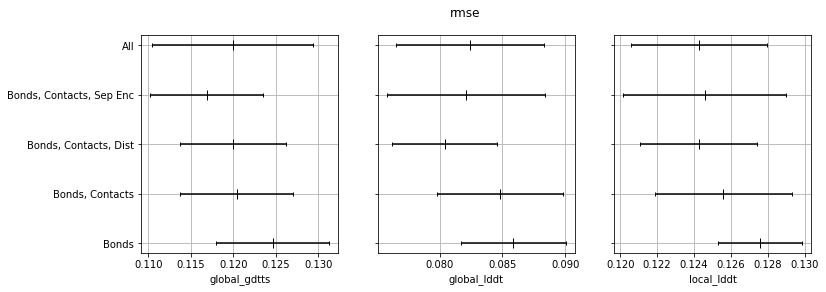

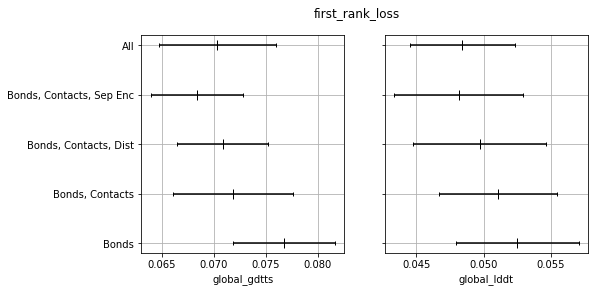

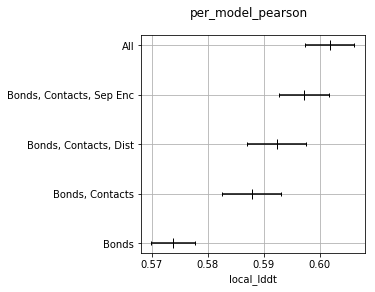

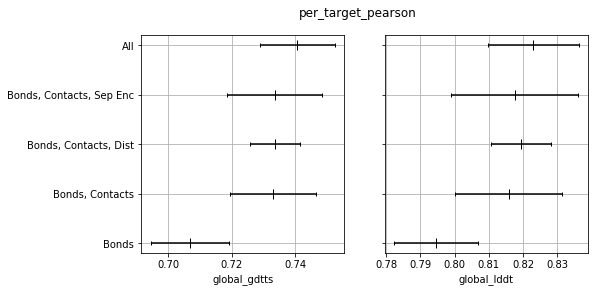

In [14]:
for metric in ['rmse', 'first_rank_loss', 'per_model_pearson', 'per_target_pearson']:
    df_metric = df_edges.loc[:, ix[:, metric]].droplevel(1, axis='columns')
    df_metric.columns = df_metric.columns.remove_unused_levels()
        
    fig, axes = plt.subplots(1, len(df_metric.columns.levels[0]), squeeze=False, facecolor='white',
                             figsize=(4*len(df_metric.columns.levels[0]), 4), sharey=True)
    fig.suptitle(metric)
    
    for ax, col in zip(axes.flat, df_metric.columns.levels[0]):
        ax.errorbar(y=df_metric.index, x=df_metric[(col, 'mean')], xerr=df_metric[(col, 'std')], 
                    linestyle='', marker='|', markersize=10, color='k', ecolor='k', capsize=2)
        ax.set_xlabel(col)
        ax.grid()
    
    display(df_metric
            .style
            .background_gradient(subset=df_metric.columns.get_loc_level('mean', level=1)[0])
            .set_caption(f'<h3 align="left">{metric}</h3>')
    )
    display(fig)
    plt.close(fig)
    del df_metric

In [15]:
del df_edges

## Architecture: global path or not

In [16]:
df_arch = df[df.misc.tags.str.contains('architecture')] \
    .drop(columns=('metric', 'global_lddt')) \
    .groupby(('misc','tags')) \
    .aggregate(['mean', 'std']).metric
df_arch.index = df_arch.index.rename('Global Pathway').str.replace('ablation,architecture,global','')
df_arch.columns = df_arch.columns.droplevel(2).remove_unused_levels()
df_arch = df_arch.loc[sorted(df_arch.index.values, key=lambda s: (s.count(','), s))]
df_arch.round(3).style

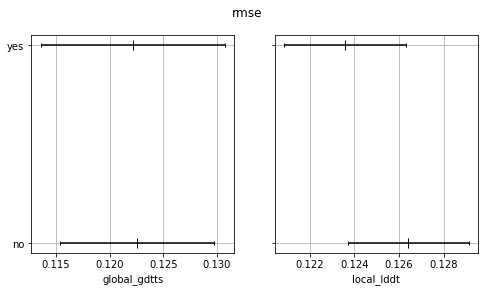

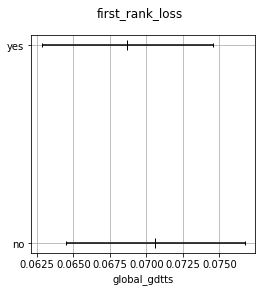

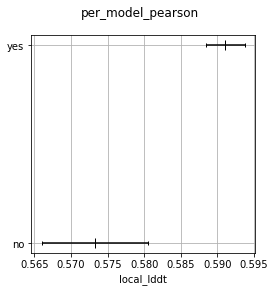

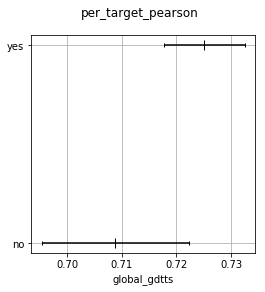

In [17]:
for metric in ['rmse', 'first_rank_loss', 'per_model_pearson', 'per_target_pearson']:
    df_metric = df_arch.loc[:, ix[:, metric]].droplevel(1, axis='columns')
    df_metric.columns = df_metric.columns.remove_unused_levels()
        
    fig, axes = plt.subplots(1, len(df_metric.columns.levels[0]), squeeze=False, facecolor='white',
                             figsize=(4*len(df_metric.columns.levels[0]), 4), sharey=True)
    fig.suptitle(metric)
    
    for ax, col in zip(axes.flat, df_metric.columns.levels[0]):
        ax.errorbar(y=df_metric.index, x=df_metric[(col, 'mean')], xerr=df_metric[(col, 'std')], 
                    linestyle='', marker='|', markersize=10, color='k', ecolor='k', capsize=2)
        ax.set_xlabel(col)
        ax.grid()
    
    display(df_metric
            .style
            .background_gradient(subset=df_metric.columns.get_loc_level('mean', level=1)[0])
            .set_caption(f'<h3 align="left">{metric}</h3>')
    )
    display(fig)
    plt.close(fig)
    del df_metric

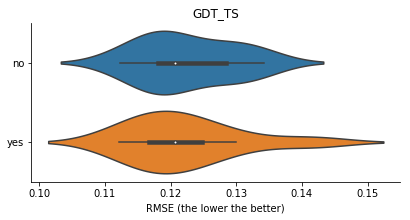

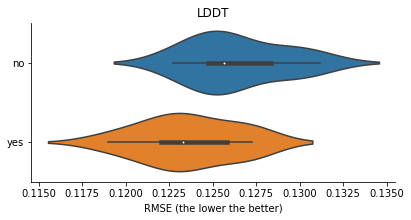

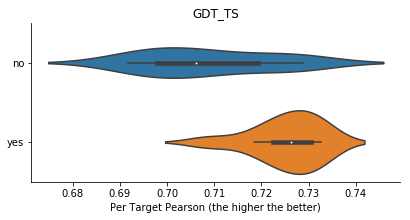

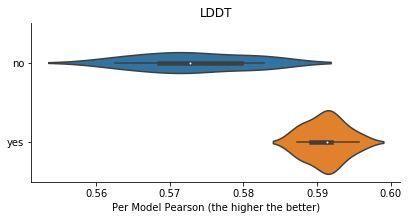

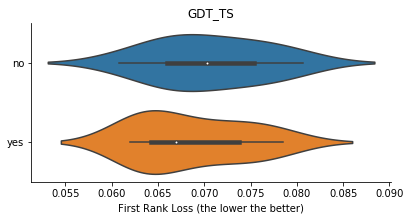

In [18]:
df_arch = df[df.misc.tags.str.contains('architecture')].set_index(('misc','tags','','')).metric
df_arch.index = df_arch.index.rename('Ablation').str.replace('ablation,architecture,global','')
df_arch.set_axis(df_arch.columns.droplevel(2), inplace=True, axis='columns')

for title, slicer in {
    ('GDT_TS','RMSE'): ('global_gdtts','rmse'),
    ('LDDT','RMSE'): ('local_lddt','rmse'),
    ('GDT_TS','Per Target Pearson'): ('global_gdtts','per_target_pearson'),
    ('LDDT','Per Model Pearson'): ('local_lddt','per_model_pearson'),
    ('GDT_TS','First Rank Loss'): ('global_gdtts','first_rank_loss'),
}.items():
    b = sns.catplot(
        y=('Ablation',''), 
        x=slicer, 
        kind="violin", 
        data=df_arch.reset_index(), 
        aspect=2,
        height=3
    )
    b.fig.set_facecolor('white')
    b.ax.set_title(title[0])
    b.ax.set_ylabel(None)
    b.ax.set_xlabel(title[1] + (' (the lower the better)' if 'Loss' in title[1] or 'RMSE' in title else ' (the higher the better)'))
    
    display(b.fig)
    b.fig.savefig(f'globalpath_{slicer[0].split("_")[1]}_{slicer[1]}.pdf')
    plt.close(b.fig)

In [19]:
del df_arch

## Local vs Global Optimization

Does optimizing together help?

In [20]:
df_localglobalscore = df[df.misc.tags.str.contains('localglobalscore')].groupby(('misc','tags')).aggregate(['mean', 'std']).metric
df_localglobalscore.index = df_localglobalscore.index.rename('Global Features') \
    .str.replace('ablation,localglobalscore,','') \
    .str.replace('local,global','both') \
    .str.capitalize()
df_localglobalscore.columns = df_localglobalscore.columns.droplevel(2).remove_unused_levels()
df_localglobalscore = df_localglobalscore.sort_index(ascending=False)
df_localglobalscore.round(3)

global_gdtts                                       \
                first_rank_loss        kendall        pearson          
                           mean    std    mean    std    mean    std   
Global Features                                                        
Local            0.231           0.138 -0.020   0.512  0.004   0.681   
Global           0.079           0.006  0.708   0.011  0.884   0.010   
Both             0.070           0.005  0.732   0.011  0.905   0.009   

                                                                     \
                per_target_kendall        per_target_pearson          
                              mean    std               mean    std   
Global Features                                                       
Local           -0.009              0.269  0.096              0.460   
Global           0.423              0.007  0.700              0.005   
Both             0.448              0.014  0.724              0.020   

                                                                          \
                per_target_spearman          rmse        spearman          
                               mean    std   mean    std     mean    std   
Global Features                                                            
Local           -0.009               0.366  0.278  0.011 -0.009    0.683   
Global           0.576               0.009  0.129  0.007  0.894    0.007   
Both             0.605               0.016  0.117  0.006  0.910    0.008   

                    global_lddt                                       \
                first_rank_loss        kendall        pearson          
                           mean    std    mean    std    mean    std   
Global Features                                                        
Local            0.210           0.127  0.049   0.577  0.066   0.747   
Global           0.211           0.000 NaN     NaN    NaN     NaN      
Both             0.211           0.000 NaN     NaN    NaN     NaN      

                                                                     \
                per_target_kendall        per_target_pearson          
                              mean    std               mean    std   
Global Features                                                       
Local            0.018              0.318 -0.007              0.454   
Global          NaN                NaN    NaN                NaN      
Both            NaN                NaN    NaN                NaN      

                                                                          \
                per_target_spearman          rmse        spearman          
                               mean    std   mean    std     mean    std   
Global Features                                                            
Local            0.024               0.425  0.235  0.021  0.069    0.751   
Global          NaN                 NaN     0.208  0.000 NaN      NaN      
Both            NaN                 NaN     0.208  0.000 NaN      NaN      

                local_lddt                                                
                   pearson        per_model_pearson          rmse         
                      mean    std              mean    std   mean    std  
Global Features                                                           
Local            0.858      0.002  0.598             0.003  0.121  0.002  
Global          -0.025      0.693  0.002             0.318  0.284  0.064  
Both             0.852      0.006  0.588             0.005  0.123  0.004

first_rank_loss        per_target_pearson          rmse       
                           mean    std               mean    std   mean    std
Global Features                                                               
Global           0.079           0.006  0.700              0.005  0.129  0.007
Both             0.070           0.005  0.724              0.020  0.117  0.006

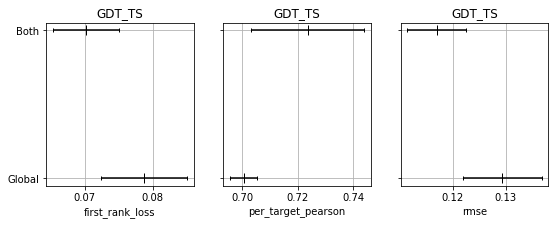

In [21]:
df_globalscore = df_localglobalscore \
    .loc[['Global', 'Both'], [c for c in df_localglobalscore.columns if c[0] == 'global_gdtts' and c[1] in {'per_target_pearson', 'rmse', 'first_rank_loss'}]]
df_globalscore.set_axis(df_globalscore.columns.droplevel(0).remove_unused_levels(), axis='columns', inplace=True)
display(df_globalscore.round(3))

fig, axes = plt.subplots(1, len(df_globalscore.columns.unique(level=0)), figsize=(len(df_globalscore.columns.unique(level=0)) * 3, 3), sharey=True)
for ax, col in zip(axes, df_globalscore.columns.unique(level=0)):
    ax.errorbar(y=df_globalscore.index, x=df_globalscore[(col, 'mean')], xerr=df_globalscore[(col, 'std')], 
                linestyle='', marker='|', markersize=10, color='k', ecolor='k', capsize=2)
    ax.set_title('GDT_TS')
    ax.set_xlabel(col)
    ax.grid()

per_model_pearson          rmse       
                             mean    std   mean    std
Global Features                                       
Local            0.598             0.003  0.121  0.002
Both             0.588             0.005  0.123  0.004

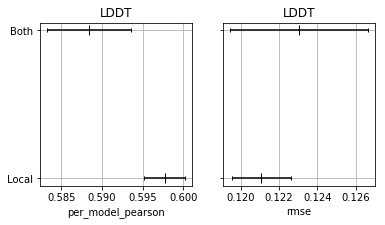

In [22]:
df_localscore = df_localglobalscore \
    .loc[['Local', 'Both'], [c for c in df_localglobalscore.columns if c[0] == 'local_lddt' and c[1] in {'per_model_pearson', 'rmse'}]]
df_localscore.set_axis(df_localscore.columns.droplevel(0).remove_unused_levels(), axis='columns', inplace=True)
display(df_localscore.round(3))

fig, axes = plt.subplots(1, len(df_localscore.columns.unique(level=0)), figsize=(len(df_localscore.columns.unique(level=0)) * 3, 3), sharey=True)
for ax, col in zip(axes, df_localscore.columns.unique(level=0)):
    ax.errorbar(y=df_localscore.index, x=df_localscore[(col, 'mean')], xerr=df_localscore[(col, 'std')], 
                linestyle='', marker='|', markersize=10, color='k', ecolor='k', capsize=2)
    ax.set_title('LDDT')
    ax.set_xlabel(col)
    ax.grid()

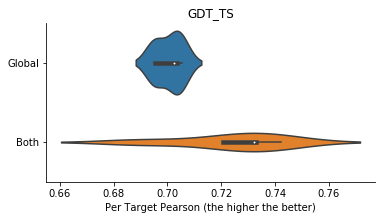

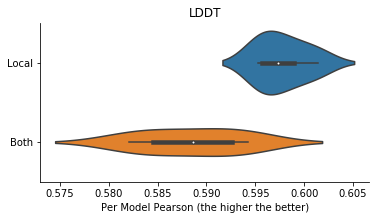

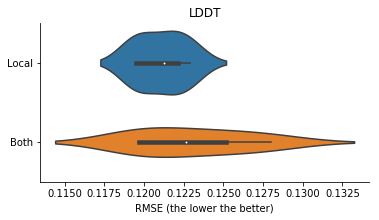

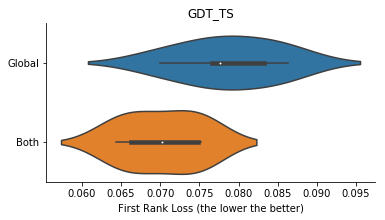

In [23]:
df_localglobalscore = df[df.misc.tags.str.contains('localglobalscore')].drop(columns=('metric', 'global_lddt')).set_index(('misc','tags','','')).sort_index()
df_localglobalscore.index = df_localglobalscore.index.rename('Ablation').str.replace('ablation,localglobalscore,','')

for title, slicer in {
    ('GDT_TS','Per Target Pearson'): ('metric','global_gdtts','per_target_pearson',''),
    ('LDDT','Per Model Pearson'): ('metric','local_lddt','per_model_pearson',''),
    ('LDDT','RMSE'): ('metric','local_lddt','rmse',''),    
    ('GDT_TS','First Rank Loss'): ('metric','global_gdtts','first_rank_loss',''),    
}.items():
    df_sub = df_localglobalscore[df_localglobalscore.index.str.contains('local' if 'LDDT' in title else 'global')]
    b = sns.catplot(
        y=('Ablation','','',''), 
        x=slicer, 
        kind="violin", 
        data=df_sub.reset_index(), 
        aspect=2,
        height=3
    )
    b.fig.set_facecolor('white')
    b.ax.set_title(title[0])
    b.ax.set_ylabel(None)
    b.ax.set_yticklabels(['Both' if ',' in label._text else label._text.capitalize() for label in b.ax.get_yticklabels()])
    b.ax.set_xlabel(title[1] + (' (the lower the better)' if 'Loss' in title[1] or 'RMSE' in title[1] else ' (the higher the better)'))
        
    display(b.fig)
    b.fig.savefig(f'localglobalscore_{slicer[1].split("_")[1]}_{slicer[2]}.pdf')
    plt.close(b.fig)
    del df_sub

In [24]:
del df_localglobalscore, df_localscore, df_globalscore

## Layers vs. Cutoff
- Careful with global pathway on/off

In [25]:
df[df.misc.ablation == 'layersvscutoff'] \
    .set_index([('hp','model','fn',''), ('hp','model','layers',''), ('hp', 'data','cutoff', '')]) \
    .metric \
    .rename_axis(index=['GlobalPath', 'Layers', 'Cutoff']) \
    .sort_index() \
    .groupby(['GlobalPath', 'Layers', 'Cutoff']) \
    .size() \
    .unstack('GlobalPath') \
    .style \
    .format(lambda v: f'{v:.0f}' if np.isfinite(v) else '/')

In [26]:
df_layersvscutoff = df[df.misc.ablation == 'layersvscutoff'] \
    .set_index([('hp','model','fn',''), ('hp','model','layers',''), ('hp', 'data','cutoff', '')]) \
    .metric \
    .rename_axis(index=['GlobalPath', 'Layers', 'Cutoff']) \
    .sort_index() \
    .groupby(['GlobalPath', 'Layers', 'Cutoff']).agg(['mean', 'std'])
df_layersvscutoff.set_axis(df_layersvscutoff.columns.droplevel(2).remove_unused_levels(), axis='columns', inplace=True)
df_layersvscutoff.round(3)

global_gdtts         \
                                                  first_rank_loss          
                                                             mean    std   
GlobalPath                          Layers Cutoff                          
proteins.networks.ProteinGN         3      0       0.080           0.004   
                                           6       0.072           0.004   
                                           8       0.070           0.003   
                                           10      0.072           0.006   
                                           12      0.067           0.003   
                                           14      0.075           0.007   
                                    6      0       0.076           0.005   
                                           6       0.072           0.004   
                                           8       0.067           0.004   
                                           10      0.066           0.006   
                                           12      0.069           0.005   
                                           14      0.072           0.005   
                                    9      0       0.081           0.007   
                                           6       0.066           0.004   
                                           8       0.067           0.002   
                                           10      0.064           0.007   
                                           12      0.073           0.004   
proteins.networks.ProteinGNNoGlobal 3      0       0.074           0.006   
                                           6       0.065           0.007   
                                           8       0.065           0.003   
                                           10      0.063           0.004   
                                           12      0.069           0.006   
                                           14      0.065           0.004   
                                    6      0       0.069           0.005   
                                           6       0.070           0.005   
                                           8       0.068           0.005   
                                           10      0.066           0.005   
                                           12      0.070           0.007   
                                    9      0       0.074           0.005   
                                           6       0.063           0.005   
                                           8       0.063           0.006   
                                           10      0.063           0.003   

                                                                          \
                                                  kendall        pearson   
                                                     mean    std    mean   
GlobalPath                          Layers Cutoff                          
proteins.networks.ProteinGN         3      0       0.722   0.004  0.886    
                                           6       0.738   0.008  0.908    
                                           8       0.742   0.008  0.907    
                                           10      0.753   0.005  0.918    
                                           12      0.746   0.007  0.915    
                                           14      0.744   0.009  0.909    
                                    6      0       0.718   0.019  0.890    
                                           6       0.741   0.008  0.907    
                                           8       0.748   0.007  0.912    
                                           10      0.751   0.005  0.916    
                                           12      0.739   0.007  0.911    
                                           14      0.742   0.010  0.906    
                                    9      0       0.720   0.009  0.887    
                        

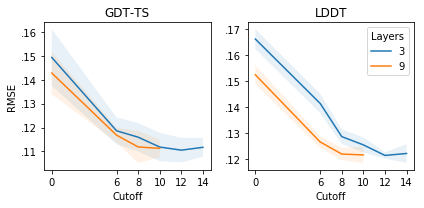

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=False)
for ax, (title, slicer) in zip(axes.flat, {
    #('GDT_TS','Per Target Pearson'): ('global_gdtts','per_target_pearson'),
    #('LDDT','Per Model Pearson'): ('local_lddt','per_model_pearson'),
    ('GDT-TS','RMSE'): ('global_gdtts','rmse'),
    ('LDDT','RMSE'): ('local_lddt','rmse'),
}.items()):
    df_slice = df_layersvscutoff.loc['proteins.networks.ProteinGNNoGlobal', slicer]
    # display(df_slice.style.set_caption(title))

    for l in [3, 9]:
        ax.plot(
            df_slice.loc[l].index,
            df_slice.loc[l, 'mean'],
            label=l
        )
        ax.fill_between(
            x=df_slice.loc[l].index,
            y1=df_slice.loc[l, 'mean'] - df_slice.loc[l, 'std'],
            y2=df_slice.loc[l, 'mean'] + df_slice.loc[l, 'std'],
            alpha=.1
        )
    ax.set_title(title[0])
    if ax.is_first_col():
        ax.set_ylabel(title[1])
    ax.set_xlabel('Cutoff')
    ax.set_xticks(df_slice.index.levels[1])
    ax.set_xticklabels(df_slice.index.levels[1])
    ax.set_yticklabels(f'{v:.2f}'[1:] for v in ax.get_yticks())
    del df_slice

axes[-1].legend(title='Layers', loc='upper right')
fig.tight_layout()
fig.savefig('./layersvscutoff_globalno.pdf', bbox_inches='tight', pad_inches=0.01)
fig.set_facecolor('white')

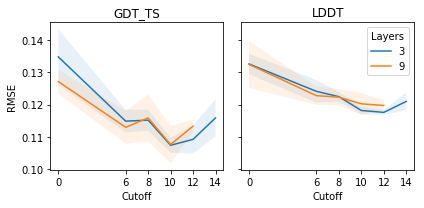

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
for ax, (title, slicer) in zip(axes.flat, {
    #('GDT_TS','Per Target Pearson'): ('global_gdtts','per_target_pearson'),
    #('LDDT','Per Model Pearson'): ('local_lddt','per_model_pearson'),
    ('GDT_TS','RMSE'): ('global_gdtts','rmse'),
    ('LDDT','RMSE'): ('local_lddt','rmse'),
}.items()):
    df_slice = df_layersvscutoff.loc['proteins.networks.ProteinGN', slicer]
    # display(df_slice.style.set_caption(title))

    for l in [3, 9]:
        ax.plot(
            df_slice.loc[l].index,
            df_slice.loc[l, 'mean'],
            label=l
        )
        ax.fill_between(
            x=df_slice.loc[l].index,
            y1=df_slice.loc[l, 'mean'] - df_slice.loc[l, 'std'],
            y2=df_slice.loc[l, 'mean'] + df_slice.loc[l, 'std'],
            alpha=.1
        )
    ax.set_title(title[0])
    if ax.is_first_col():
        ax.set_ylabel(title[1])
    ax.set_xlabel('Cutoff')
    ax.set_xticks(df_slice.index.levels[1])
    ax.set_xticklabels(df_slice.index.levels[1])
    del df_slice

axes[-1].legend(title='Layers', loc='upper right')
fig.tight_layout()
fig.savefig('./layersvscutoff_globalyes.pdf')
fig.set_facecolor('white')

Cutoff,0,6,8,10,12,14
Layers,,,,,,
3,0.69066,0.719585,0.725718,0.733807,0.739067,0.721924
6,0.701111,0.717797,0.729915,0.732944,0.736515,0.744037
9,0.692788,0.723262,0.731111,0.743871,0.750759,nan


Cutoff,0,6,8,10,12,14
Layers,,,,,,
3,0.79197,0.814635,0.826978,0.831566,0.834482,0.816186
6,0.800358,0.81945,0.829863,0.829065,0.832689,0.821762
9,0.783722,0.819741,0.824997,0.832947,0.839356,nan


Cutoff,0,6,8,10,12,14
Layers,,,,,,
3,0.0773602,0.0680904,0.0672503,0.0678379,0.0680298,0.0699956
6,0.0726687,0.0708447,0.0674962,0.0658742,0.0695237,0.0717831
9,0.0771649,0.0645809,0.0650712,0.0634209,0.0731638,nan


Cutoff,0,6,8,10,12,14
Layers,,,,,,
3,0.0532083,0.0456197,0.0438453,0.0454049,0.0421889,0.0466297
6,0.0503432,0.0487951,0.0453529,0.0443171,0.0445143,0.0499033
9,0.0527437,0.0440028,0.0463173,0.0426593,0.0480082,nan


Cutoff,0,6,8,10,12,14
Layers,,,,,,
3,0.149378,0.132786,0.125583,0.12186,0.119537,0.121605
6,0.142039,0.128527,0.121293,0.120836,0.12108,0.121932
9,0.142444,0.124719,0.12215,0.120959,0.119715,nan


Cutoff,0,6,8,10,12,14
Layers,,,,,,
3,0.528321,0.567089,0.583765,0.592813,0.601015,0.598623
6,0.545282,0.578959,0.596447,0.59957,0.601786,0.607744
9,0.539027,0.581825,0.591598,0.597931,0.602724,nan


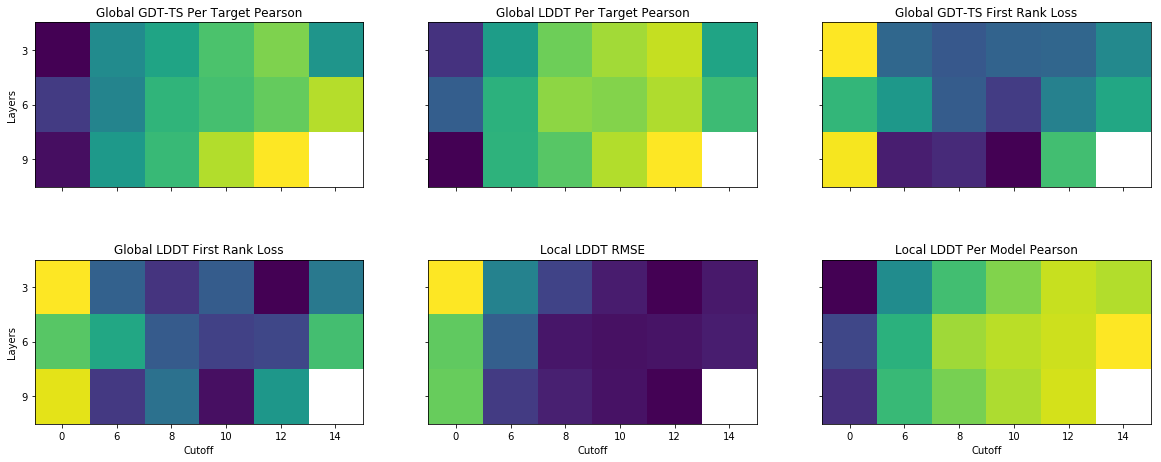

In [29]:
df_layersvscutoff_pivot = df_layersvscutoff \
    .drop('std', level=2, axis='columns') \
    .droplevel(2, axis='columns') \
    .pivot_table(index='Layers', columns='Cutoff')

fig, axes = plt.subplots(2, 3, figsize=(20, 8), sharex=True, sharey=True)
for ax, (title, slicer) in zip(axes.flat, {
    'Global GDT-TS Per Target Pearson': ('global_gdtts','per_target_pearson'),
    'Global LDDT Per Target Pearson': ('global_lddt','per_target_pearson'),
    'Global GDT-TS First Rank Loss': ('global_gdtts','first_rank_loss'),
    'Global LDDT First Rank Loss': ('global_lddt','first_rank_loss'),
    'Local LDDT RMSE': ('local_lddt','rmse'),
    'Local LDDT Per Model Pearson': ('local_lddt','per_model_pearson'),
}.items()):
    df_slice = df_layersvscutoff_pivot[slicer]
    display(df_slice.style.set_caption(title))
    ax.imshow(df_slice.values)
    ax.set_title(title)
    ax.set_xticks(np.arange(len(df_slice.columns)))
    ax.set_xticklabels(df_slice.columns)
    ax.set_yticks(np.arange(len(df_slice.index)))
    ax.set_yticklabels(df_slice.index)
    del df_slice
    
for ax in axes[-1,:]:
    ax.set_xlabel('Cutoff')
for ax in axes[:, 0]:
    ax.set_ylabel('Layers')

fig.set_facecolor('white')
display(fig)
plt.close(fig)

In [30]:
del df_layersvscutoff, df_layersvscutoff_pivot